# Naive Bayes Classification
Naive Bayes is one of the simplest and most basic classifiers. Even though its assumptions are naive, this algorithm is still quite important for various reasons:
* Even in cases where its performance is not great, it quickly establishes a baseline against which other algorithms can be benchmarked.
* Because it is so simple, it is very fast and hence very feasible even on large data sets.
* In particular with various tweaks, its model performance is sometimes better than one thinks.

In this notebook we derive the basic mathematical equations, discuss some implementation details and reconcile some simple synthetic examples with the `sklearn.naive_bayes` implementation.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, MultinomialNB, GaussianNB, ComplementNB
from numpy.testing import assert_array_almost_equal
import matplotlib.pyplot as plt
import ipywidgets as wdg

# Definitions
This principle works in a more general context given as follows.

**Setup:** Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space and $X=(X_1, \ldots, X_d)$ be a $d$-dimentional feature vector and $Y$ be a categorical variable, i.e. we assume that $Y$ can only attain finitely many values $y \in \{0, \ldots, K-1\}$ called *classes*. The features $X$ can be either categorical or continuous (see below). The sample is a labeled data set $(\mathcal{X},y) = (x_j^{(i)},y_i)_{j=1, \ldots, d; i=1, \ldots, N}$.

**Idea:** The idea of a naive Bayes classifyer is to predict a value using Bayes' Theorem
\begin{align*}
    \mathbb{P}[Y=y \mid X_1=x_1, \ldots, X_d=x_d] = \frac{\mathbb{P}[Y=y]\mathbb{P}[X_1=x_1, \ldots, X_d=x_d \mid Y=y]}{\mathbb{P}[X_1=x_1, \ldots, X_d = x_d]}
\end{align*}

**Assumption:** Under the (naive) assumption that all features are conditionally independent given $Y$, we have
\begin{align*}
    \mathbb{P}[Y=y \mid X_1=x_1, \ldots, X_d = x_d] = \frac{\mathbb{P}[Y=y]}{\mathbb{P}[X_1=x_1, \ldots, X_d=x_d]} \prod_{j=1}^{d}{\mathbb{P}[X_j = x_j \mid Y=y]},
\end{align*}
where the right hand side can be learned from the training set. 

**Prediction** is done using *maximum a posteriori (MAP)*, i.e. on a new data $x_1^*, \ldots, x_d^*$ we use
\begin{align*}
    y^* := \operatorname{argmax}_{y}{\mathbb{P}[Y=y] \prod_{j=1}^d{\mathbb{P}[X_j = x_j^* \mid Y=y]}}.
\end{align*}

Notice that the denominator $\mathbb{P}[X_1=x_1, \ldots, X_d=x_d]$ is dropped from this equation as it does not depend on $Y$). Also notice that the right hand maximizes the joint probability, since under the independence assumption
\begin{align*}
    \mathbb{P}[Y=y] \prod_{j=1}^d{\mathbb{P}[X_j = x_j^* \mid Y=y]} 
    = \prod_{j=1}^d{\mathbb{P}[X_j = x_j^*, Y=y]} 
    = \mathbb{P}[X_1 = x_1^*, \ldots, X_d = x_d^*,Y=y].
\end{align*}

# Types of Bayes Estimators

In order to practically use a naive Bayes estimator, we need to be able to calculate $\mathbb{P}[X_j = x_j \mid Y=y]$ for each possible class $y$. This is typically done by making a distributional assumption and then estimating this distribution from the data. These estimates are often performed using *smoothing* with a *smoothing parameter* $0 \leq \alpha \leq 1$, see next chapter below. 

In the following we discuss a few quite popular choices for the distributional assumptions.

## Bernoulli
Assumes that $X_j \mid Y=y$ is binary and conditionally Bernoulli distributed. We estimate the success probability via an $\alpha$-smoothed Maximum Likelihood Estimate (MLE), which is given by
\begin{align*}
    \mathbb{P}[X_j=1 \mid Y=y] \approx \theta_{j,y} := \frac{N_{j,y} + \alpha}{N_y+2 \alpha}, 
    && N_{j,y} := |\{i \mid x_i^{(j)}=1 , y_i=y\}|, 
    && N_y := |\{i \mid y_i=y\}|
\end{align*}
An $\alpha=1$ smoothing means that this probability is estimated assuming that there is $\alpha=1$ more sample in both cases $X_j=0,1$.

## Categorical/Multinulli:
Assumes that $X_j \mid Y=y$ attains only finitely many values $c \in \{0, \ldots, n_j-1\}$ and the $\alpha$-smoothed MLE of the probability of attaining those values is given by
\begin{align*}
    \mathbb{P}[X_j = c \mid Y=y] \approx \theta_{j,c,y} := \frac{N_{j,c,y}+\alpha}{N_y+\alpha n_j}
    && N_{j,c,y} := |\{i \mid x_i^{(j)}=c , y_i=y\}|, 
    && N_y := |\{i \mid y_i=y\}|
\end{align*}
An $\alpha=1$ smoothing means that this probability is estimated assuming that there is $\alpha=1$ more samples in each of the cases $X_j=0, \ldots, n_j-1$.

## Multinomial
Assumes that $X=(X_1, \ldots, X_d) \mid Y=y$ is multinomially distributed with some total count $m \in \mathbb{N}$ and some success probability vector $\theta_y=(\theta_{y,1}, \ldots, \theta_{y,d})$ satisfying $0 \leq \theta_{y,j} \leq 1$ and $\sum_{j=1}^d{\theta_{y,j}}=1$. We estimate the success probabilities from the sample via 
\begin{align*}
    \theta_{y,j} := \frac{N_{j,y} + \alpha}{N_y + \alpha d},
    && N_{j,y} := \sum_{i,y_i=y}{x_i^{(j)}}, 
    && N_y := \sum_{j=1}^d{N_{j,y}}.
\end{align*}
An $\alpha=1$ smoothing means that this probability is estimated assuming that in each category there is $\alpha=1$ more sample counted than acctually occured.

Notice that we do not estimate the $m$ i.e. the total number of trials in the multinomial distribution, but only the $\theta_y$, i.e. the success probabilities of the underlying multinulli distribution. This is because we do not actually need $m$ to make predictions. For any new piece of data $x^* = (x_1^*, \ldots, x_d^*)$, we can calculate $m^* := \sum_{j=1}^{d}{x_j^*}$. The likelihood is then given by the multinomial distribution with parameters $\theta$ and $m$, i.e.
\begin{align*}
    \mathbb{P}[X_j=x_j^* \mid Y=y] = \frac{m^*!}{\prod_{j=1}^{d}{x_j!}} \prod_{j=1}^{d}{\theta_{y,j}^{x_j^*}}.
\end{align*}
This allows us to perform training and prediction on data with varying $m$ (at least in principle). This is important as many practical applications that use a multinomial classifyer naturally have samples of varying $m$, e.g. text classification.

Also notice that the log-likelihood can be written as
\begin{align*}
    \log(\mathbb{P}[X_j=x_j^* \mid Y=y]) = \underbrace{\log(m^*!) - \log\Big(\prod_{j=1}^{d}{x_j!} \Big)}_{\text{does not depend on $y$}} +  \sum_{j=1}^d {x_j^* \log( \theta_{y,j}) } .
\end{align*}
Hence, in order determine the class of a prediction at $x^*$, since $\log$ is a monotonous function, it is equivalent to calculate
\begin{align*}
    y^* = \operatorname{argmax}_{y}{b_y +  \sum_{j=1}^d{x_j^* \omega_{y,c} }}. 
    && b_y := \log(\mathbb{P}[Y=y]), 
    &&\omega_{y,j} := \log( \theta_{y,j})
\end{align*}

## Complement
The performance of a Naive Bayes classifier can degrade if the data set is very imbalanced, e.g. if one class $Y=1$ occurs much less frequent than another, say $Y=0$. In those cases one can stabilize the estimate, by using a variant of Multinomial that is based on estimating the likelihood of *not* belonging to a class (with the same estimator as in the multinomial case) instead, i.e.
\begin{align*}
    \bar \theta_{y,j} := \frac{\bar N_{j,y} + \alpha}{\bar N_y + \alpha d},
    && \bar N_{j,y} := \sum_{i,y_i \neq y}{x_i^{(j)}}, 
    && \bar N_y := \sum_{j=1}^d{\bar N_{j,y}}.
\end{align*}
We can then calculate analogously
\begin{align*}
    b_y := \log(\mathbb{P}[Y=y]), && \bar \omega_{y,j} := \log( \bar\theta_{y,j}).
\end{align*}
Sometimes the resulting weights $\omega_{y,j}$ can now be of very uneven size, which is why one can optionally normalize them via
\begin{align*}
    \bar \omega_{y,j}' := \frac{\bar \omega_{y,j}}{\sum_{j=1}^{d}{|\bar \omega_{y,j}|}}.
\end{align*}
The prediction is made (regardless of normalization) via
\begin{align*}
    y^* = \operatorname{argmin}_{y}{b_y + \sum_{j=1}^d{x_j^* \bar \omega_{y,c}' }} 
\end{align*}
as we want the lowest probability of the class $y$ to which the sample $x^*$ does not match.
Alternatively, we can of course calculate this via
\begin{align*}
    y^* = \operatorname{argmax}_{y}{b_y - \sum_{j=1}^d{x_j^* \bar \omega_{y,c}' }}.
\end{align*}
Notice that neither $ e^{\bar \omega_{y,c}'}$ nor $e^{- \bar \omega_{y,c}}$ represent probabilities anymore.

## Gaussian
Assume $X_j = x_j \mid Y=y$ is conditionally Gaussian and estimate mean $\mu_{j,y}$ and variance $\sigma_{j,y}^2$ via Maximum Likelihood estimators (MLE)
\begin{align*}
    \mu_{j,y} := \frac{\sum_{i,y_i=y}{x_i^{(j)}}}{|\{i \mid y_i=y\}|}, &&
    \sigma_{j,y}^2 := \frac{\sum_{i,y_i=y}{(x_i^{(j)}-\mu_{j,y})^2}}{|\{i \mid y_i=y\}|}.
\end{align*}
Predictions are being made using the PDF of the conditional distributions $\mathbb{P}[X_j=j \mid Y=y]$ and the PMF of the classes $\mathbb{P}[Y=y]$.

# Smoothing

When estimating probabilities, we often use a smoothing parameter $0 \leq \alpha \leq 1$. The case $\alpha=0$ is equivalent to no smoothing applied, the case $0 < \alpha < 1$ is called *Lidstone smoothing* and the case $\alpha=1$ is called *Laplace smoothing*. The reason why we apply smoothing is that it is naive to assume that the training set we are given is the entirety of samples that can theoretically occur. This is particularly awkward if certain cases do not occur at all in the training set, as this will lead to a zero estimate for the corresponding probability. In particular for data sets with a large number of features, e.g. word counts in text classification, this is not uncommon. The simple solution is to increate every count by $\alpha=1$, which is why this is also sometimes called *add-one smoothing*. Using a smaller number $0 < \alpha < 1$ allows us to fine tune this a bit better.

# Combining multiple Naive Bayes estimators

Notice that if you have two features $X_1$ and $X_2$ and their conditional distributions given $Y$ are different, e.g. $X_1$ is Bernoulli and $X_2$ is Gaussian, then due to the independence assumption they can still be combined into one Naive Bayes estimator using the same formula, i.e.
\begin{align*}
    y^* := \operatorname{argmax}_{y}{\mathbb{P}[Y=y] \mathbb{P}[X_1 = x_1^* \mid Y=y] \mathbb{P}[X_2 = x_2^* \mid Y=y]}.
\end{align*}

# Remarks on Implementation

## Internal model consistency
When implementing a Bayes model, one has a choice, which probabilities are directly estimated from data and which are calculated out of previous estimates. This might not always give the same result. For example assuming $X_0,Y_1,Y$ are all binary, $\mathbb{P}[X_0=0,X_1=1\mid Y=0]$ estimated by counting from the data might give a different result than multiplying the estimated values $\mathbb{P}[X_0=0\mid Y=0]\mathbb{P}[X_1=1\mid Y=0]$ even though mathematically this holds true under the assumptions of the model. This is because the estimation from the data has to work with finite samples and even if they are drawn from distributions that perfectly match the model assumptions, we get different values - and of course the model assumptions might not hold perfectly (or not at all). 

A good strategy to deal with this is to aim for *internal model consistency*, i.e. to estimate the most atomic probabilities needed for the model and calculate everything else out of these atomic probabilities. This does not prevent the model from giving a wrong result, but it ensures that under the model assumptions all calculations are internally consistent. 
In more detail, this means that we can calculate:
1. Prior: estimate the prior $\mathbb{P}[Y=y]$ directly from the data (or specify manually)
2. Likelihood: estimate the parameters to determine $\mathbb{P}[X_j=x \mid Y=y]$ directly from the data.
3. Calculate everything else out of it, in particular
    * joint likelihoods as $\mathbb{P}[X_j=x,Y=y] = \mathbb{P}[X_j=x \mid Y=y] \mathbb{P}[Y=y]$
    * marginal likelihoods by summation over joint likelihoods, i.e. $\mathbb{P}[X_j=x] = \sum_y \mathbb{P}[X_j=x,Y=y]$
    * posteriors by dividing joint likelihoods by marginal likelihoods, i.e. $\mathbb{P}[Y=y \mid X_j=x] = \mathbb{P}[X_j=x,Y=y] / \mathbb{P}[X_j=x]$
    
This calculation of probabilities from the prior and the likelihoods ensures internal consistency and is numerically efficient and used in popular implementations such as `sklearn.naive_bayes`.

## Logarithmic probabilities
It is natural to formulate and describe a Bayes model using the probabilities themselves, because this is how Bayes' Theorem is formulated. Implementing a Bayes model using the probabilities directly can lead to numerical instabilities. In applications such as text classification the number of features can be very large, but the probabilities of some features can be very small. This means that an expression like 
\begin{align*}
    \mathbb{P}[Y=y] \prod_{j=1}^d{\mathbb{P}[X_j = x_j^*]}
\end{align*}
amounts to multiplying a large number of values all of which are very small. This means that this number can be so small that it suffers from *underflow*, i.e. becoming zero as a floating point even though it is actually still non-zero, but very very small. A simple way to avoid this problem is to use the log-probabilities instead, i.e. to work with
\begin{align*}
    \log(\mathbb{P}[Y=y]) + \sum_{j=1}^d{\log(\mathbb{P}[X_j = x_j^*])}
\end{align*}
instead. Popular implementations such as `sklearn.naive_bayes` use this strategy to improve numeric stability.

# Examples

## Introductory
Assume we are given only one feature $X$ and we want to predict a binary label $Y$. An easy example is to assume that both $\mathbb{P}[X \mid Y=0]$ and $\mathbb{P}[X \mid Y=1]$ are Gaussian, but with different means and variances resulting in different conditional likelihoods $p(x \mid y=0)$ and $p(x \mid y=1)$. For any given sample of $x$ we simply evaluate which one is bigger and classify it accordingly.

Assuming a given prior $p(y)$ we can slightly refine this by using the likelihoods $p(x,y=0)=p(x \mid y=0)p(y=0)$ and $p(x,y=1)=p(x \mid y=1)p(y=1)$ instead. 

<IPython.core.display.Javascript object>


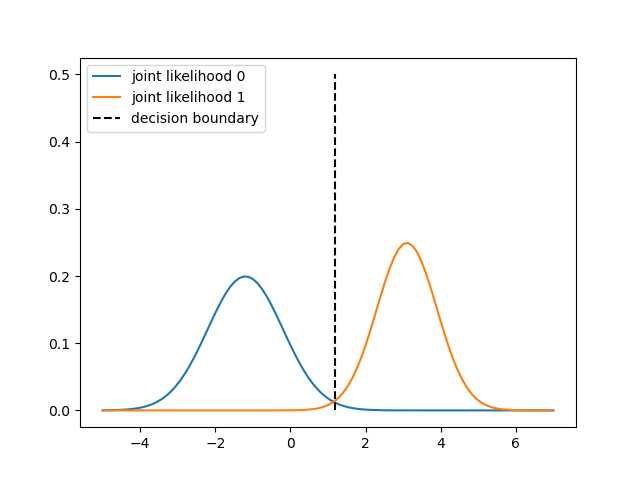

interactive(children=(FloatSlider(value=-1.2, description='mu0', max=5.0, min=-5.0), FloatSlider(value=1.0, de…

In [2]:
fig, ax = plt.subplots()

x_grid = np.linspace(-5,7,100)

@wdg.interact(mu0=wdg.FloatSlider(min=-5, max=5, step=0.1, value=-1.2),
             sigma0=wdg.FloatSlider(min=0, max=2, step=0.1, value=1),
             mu1=wdg.FloatSlider(min=-5, max=5, step=0.1, value=3.1),
             sigma1=wdg.FloatSlider(min=0, max=2, step=0.1, value=0.8),
             prior_p=wdg.FloatSlider(min=0, max=1, step=0.1, value=0.5)
             )
def plot(mu0, sigma0, mu1, sigma1, prior_p):
    
    ax.clear()
    
    # conditional likelihoods
    llh0 = ss.norm(loc=mu0, scale=sigma0).pdf(x_grid)
    llh1 = ss.norm(loc=mu1, scale=sigma1).pdf(x_grid)
    
    # prior
    prior = np.array([1-prior_p, prior_p])
    
    # joint likelihoods    
    jllh0 = llh0 * prior[0]
    jllh1 = llh1 * prior[1]
    
    # marginal likelihood
    marginal = jllh0 + jllh1
    
    # posterior
    posterior0 = jllh0 / marginal
    posterior1 = jllh1 / marginal
    
    
    
    ax.plot(x_grid, jllh0, label='joint likelihood 0')
    ax.plot(x_grid, jllh1, label='joint likelihood 1')
    ax.vlines(x=x_grid[np.argmin(jllh0 > jllh1)], ymin=0, ymax=0.5, color='k', label="decision boundary", linestyle='--')
    #ax.plot(x_grid, posterior0, label='posterior 0')
    #ax.plot(x_grid, posterior1, label='posterior 1')
    #ax.plot(x_grid, marginal, label='marginal')
    
    #ax.set_ylim([0,1.1])
    ax.legend(loc='upper left')

plt.show()

## Basic Bernoulli/Binary Case
In this example we assume that there are only two classes $Y \in \{0,1\}$ and one binary features $X \in \{0,1\}$. We manually synthesize data according to the likelihoods.

In [3]:
# create synthetic test data
np.random.seed(1)
num_successes = 50
num_failures = 100
success_prob_per_class = np.array([0.2, 0.4])

y = np.hstack((np.zeros(num_failures), np.ones(num_successes)))
X = np.hstack((np.random.binomial(size=num_failures, n=1, p=success_prob_per_class[0]),
               np.random.binomial(size=num_successes, n=1, p=success_prob_per_class[1])))[:, np.newaxis]

In [4]:
# fit the model
alpha = 1
clf = BernoulliNB(alpha=alpha,force_alpha=True)
clf.fit(X,y)

BernoulliNB(alpha=1, force_alpha=True)

In [5]:
# total empirical success probabilities of the classes
print("Classes: ")
print(clf.classes_)
print()
print("Prior")
prior = np.exp(clf.class_log_prior_) 
print(prior)

# prior sanity check
prior_rec = np.array([num_failures / (num_failures + num_successes), 
                      num_successes / (num_failures + num_successes)])
assert_array_almost_equal(prior, prior_rec)

Classes: 
[0. 1.]

Prior
[0.66666667 0.33333333]


In [6]:
# empirical conditional success probabilities of the features given the class
print("Conditional success probabilities (smoothed estimate):")
feature_prob = np.exp(clf.feature_log_prob_)
print(feature_prob)
print()

# Likelihood: Sanity check: (P(x=1 | y=0), P(x=1 | y=1))")
feature_prob_rec = np.array([ (X[:num_failures,:][X[:num_failures,:]==1].shape[0] + alpha)/ (num_failures + 2 * alpha), \
(X[num_failures:,:][X[num_failures:,:]==1].shape[0] + alpha) / ( num_successes + 2 * alpha)])[:, np.newaxis]
assert_array_almost_equal(feature_prob, feature_prob_rec)

print("Conditional success probabilities (truth):")
print(success_prob_per_class[:, np.newaxis])

Conditional success probabilities (smoothed estimate):
[[0.19607843]
 [0.40384615]]

Conditional success probabilities (truth):
[[0.2]
 [0.4]]


In [7]:
# predict for each value of the feature the joint probability with a class for every class
print("Predict joint probabilities:")
joint_proba = np.exp(clf.predict_joint_log_proba(clf.classes_[:, np.newaxis])) # P(x=0,1,y=0,1)
print(joint_proba)

joint_proba_rec = np.vstack((1-feature_prob[:,0] ,feature_prob[:,0])) * prior
assert_array_almost_equal(joint_proba, joint_proba_rec)

Predict joint probabilities:
[[0.53594771 0.19871795]
 [0.13071895 0.13461538]]


In [8]:
# compute marginal likelihood
marginal_likelihood = joint_proba.sum(axis=1)
if alpha==0: # if no smoothing, we can reconcile marginal likelihood directly with data
    marginal_likelihood_rec_data = np.array([X[X==0].shape[0], X[X==1].shape[0]]) / (X.shape[0]) # (P(x=0), P(x=1))
    assert_array_almost_equal(marginal_likelihood, marginal_likelihood_rec_data)

In [9]:
# predict for each value of the feature the probability to belong to a class for every class
print("Posterior:")
posterior = np.exp(clf.predict_log_proba(clf.classes_[:, np.newaxis]))  #(n_features, n_classes)
print(posterior)

# Posterior: Sanity Check (Bayes formula)
posterior_rec = joint_proba / marginal_likelihood[:, np.newaxis]
assert_array_almost_equal(posterior, posterior_rec)

Posterior:
[[0.7295124  0.2704876 ]
 [0.49265751 0.50734249]]


In [10]:
# predictions for x=[0,1]
clf.predict(clf.classes_[:, np.newaxis])

array([0., 1.])

## Categorical Features / Multiclass case

In this example we assume that there are three classes $Y \in \{0,1,2\}$ and two features, where $X_0 \in \{0,1\}$ and $X_1 \in \{0,1,2\}$. We synthesize data according to the likelihoods

In [11]:
# create synthetic data
n_samples_per_class= 100
np.random.seed(1)

df_likelihoods = [
    pd.DataFrame(columns=['X_0=0', 'X_0=1','Y'],data=
    [[0.8, 0.2,0],
    [0.6, 0.4,1],
    [0.4, 0.6,2]]),
    pd.DataFrame(columns=['X_1=0', 'X_1=1', 'X_1=2', 'Y'],data=
    [[0.8, 0.15, 0.05, 0],
    [0.7, 0.2, 0.1, 1],
    [0.6, 0.3, 0.1, 2]])]

df_likelihood = []
for y in [0,1,2]:
    for x0 in [0,1]:
        for x1 in [0, 1, 2]:
            df_likelihood.append([x0,x1,y,df_likelihoods[0].iloc[y,x0]*df_likelihoods[1].iloc[y,x1]])
df_likelihood = pd.DataFrame(data=df_likelihood, columns=['X0', 'X1', 'Y', 'P'])

x_vals = np.array([[x0,x1] for x0 in [0,1] for x1 in [0, 1, 2]])
x_vals_dict = {k:v for k,v in enumerate(x_vals)}
df=pd.DataFrame(data=np.vstack([np.array([x_vals_dict[i]
                                          for i in np.random.choice(6,size=n_samples_per_class,
                                                                    p=df_likelihood[df_likelihood['Y']==y]['P'])])
                                for y in range(3)]),
                columns=['X0','X1'])
df['Y'] = np.hstack([np.ones(n_samples_per_class, dtype=np.int64) * y for y in range(3)])

In [12]:
# fit the model
alpha=1
clf = CategoricalNB(alpha=alpha, force_alpha=True)
clf.fit(df[['X0','X1']].values, df['Y'].values)

CategoricalNB(alpha=1, force_alpha=True)

In [13]:
# show output
print("Classes: ")
print(clf.classes_)
print()
print("Prior:")
prior = np.exp(clf.class_log_prior_)
print(prior)

Classes: 
[0 1 2]

Prior:
[0.33333333 0.33333333 0.33333333]


In [14]:
print("Likelihood for feature X0 (estimated):")
likelihood = [np.exp(clf.feature_log_prob_[y]) for y in range(2)] 
print(likelihood[0]) # (n_classes, n_feature_values)
print()
print("Likelihood for feature X0 (truth):")
print(df_likelihoods[0])
print()
print("Likelihood for feature X1 (estimated):")
print(likelihood[1])
print()
print("Likelihood for feature X1 (truth):")
print(df_likelihoods[1])

likelihood_rec = [np.vstack([df[df['Y']==y][feature].value_counts().sort_index().values + alpha for y in range(3)]) / (n_samples_per_class + alpha * clf.n_categories_[fi])
                  for fi, feature in enumerate(['X0', 'X1'])]
assert_array_almost_equal(likelihood[0], likelihood_rec[0])
assert_array_almost_equal(likelihood[1], likelihood_rec[1])

Likelihood for feature X0 (estimated):
[[0.80392157 0.19607843]
 [0.58823529 0.41176471]
 [0.31372549 0.68627451]]

Likelihood for feature X0 (truth):
   X_0=0  X_0=1  Y
0    0.8    0.2  0
1    0.6    0.4  1
2    0.4    0.6  2

Likelihood for feature X1 (estimated):
[[0.78640777 0.19417476 0.01941748]
 [0.69902913 0.14563107 0.15533981]
 [0.53398058 0.33009709 0.13592233]]

Likelihood for feature X1 (truth):
   X_1=0  X_1=1  X_1=2  Y
0    0.8   0.15   0.05  0
1    0.7   0.20   0.10  1
2    0.6   0.30   0.10  2


In [15]:
print("Prediction for each feature vector: ")
df_pred =pd.concat([
    pd.DataFrame(data=x_vals, columns=['X0', 'X1']),
    pd.DataFrame(data=clf.predict_proba(x_vals), columns=['PY0','PY1','PY2'])
], axis=1)
df_pred['pred'] = clf.predict(x_vals)
print(df_pred)

# reconcile predicted probabilities with Bayes formula
joint_proba_rec = np.array([[likelihood[0][y,x0] * likelihood[1][y,x1] * prior[y] 
                             for x0 in range(2)
                             for x1 in range(3)] 
                            for y in range(3)])
proba_rec = (joint_proba_rec / joint_proba_rec.sum(axis=0)).T
assert_array_almost_equal(df_pred[['PY0', 'PY1', 'PY2']], proba_rec)

Prediction for each feature vector: 
   X0  X1       PY0       PY1       PY2  pred
0   0   0  0.522088  0.339569  0.138343     0
1   0   1  0.452040  0.248071  0.299890     0
2   0   2  0.104326  0.610687  0.284987     1
3   1   0  0.190723  0.356016  0.453261     2
4   1   1  0.117302  0.184751  0.697947     2
5   1   2  0.023641  0.397163  0.579196     2


# Multinomial Features
In this example we assume that there are two classes $Y \in \{0,1\}$ and two multinomial features $X_j$.

In [16]:
# generate data
n = 100  # number of samples per class
m = 50  # max count per feature
p = np.array([[0.2, 0.8],
              [0.6, 0.4]])  # underlying success probabilities P[X_j=k | Y = y]

np.random.seed(1)

XY0 = ss.multinomial(m, p[0, :]).rvs(n)
XY1 = ss.multinomial(m, p[1, :]).rvs(n)

df = pd.DataFrame(data={
    'X0': np.hstack((XY0[:,0] ,XY1[:,0])),
    'X1': np.hstack((XY0[:,1] ,XY1[:,1])),
    'Y': np.hstack((np.zeros(n, dtype=np.int64),np.ones(n, dtype=np.int64)))
})

In [17]:
# instantiate and fit the model
alpha=1
clf = MultinomialNB(alpha=alpha, force_alpha=True)
clf.fit(df[['X0','X1']].values, df['Y'].values)

MultinomialNB(alpha=1, force_alpha=True)

In [18]:
# estimated prior
print("Prior:")
prior = np.exp(clf.class_log_prior_)
print(prior)

Prior:
[0.5 0.5]


In [19]:
# estimated feature probabilities
print("Conditional feature probabilities (estimate):")
feature_prob = np.exp(clf.feature_log_prob_) # (n_classes, n_features)
print(feature_prob)
print()
print("Conditional feature probabilities (truth):")
print(p)

# reconcile feature probabilities
feature_prob_rec = np.array([
    [(df[df['Y']==0]['X0'].sum() + alpha)/ (df[df['Y']==0]['X0'].sum()+df[df['Y']==0]['X1'].sum() + 2*alpha), 
     (df[df['Y']==0]['X1'].sum() + alpha)/ (df[df['Y']==0]['X0'].sum()+df[df['Y']==0]['X1'].sum() + 2*alpha)],
    [(df[df['Y']==1]['X0'].sum() + alpha)/ (df[df['Y']==1]['X0'].sum()+df[df['Y']==1]['X1'].sum() + 2*alpha), 
     (df[df['Y']==1]['X1'].sum() + alpha)/ (df[df['Y']==1]['X0'].sum()+df[df['Y']==1]['X1'].sum() + 2*alpha)]
])
assert_array_almost_equal(feature_prob, feature_prob_rec)

Conditional feature probabilities (estimate):
[[0.19492203 0.80507797]
 [0.60455818 0.39544182]]

Conditional feature probabilities (truth):
[[0.2 0.8]
 [0.6 0.4]]


In [20]:
# example prediction
x_new = np.array([[20,30]])
predict_proba = clf.predict_proba(x_new)
print("Predict Probabilities:")
print(predict_proba)

# reconcile probabilities
joint_proba = np.array([ss.multinomial(m, feature_prob[y, :]).pmf(x_new[0,:]) * prior[y] for y in range(2)])
marginal_likelihood = joint_proba.sum()
predict_proba_rec = joint_proba / marginal_likelihood
assert_array_almost_equal(predict_proba[0,:], predict_proba_rec)

Predict Probabilities:
[[0.21250327 0.78749673]]


In [21]:
# predict class
print("Prediction: ")
clf.predict(x_new)

Prediction: 


array([1], dtype=int64)

## Complement
In cases where the distribution of classes is skewed, e.g. there are way more failures $Y=0$ than successes $Y=1$, one estimate all probabilities based on complements, which results in better model performance.

In [22]:
# generate data
n_failure = 100  # number of samples per class
n_success = 20  # number of samples per class

m = 50  # max count per feature
p = np.array([[0.2, 0.8],
              [0.6, 0.4]])  # underlying success probabilities P[X_j=k | Y = y]

np.random.seed(1)

XY0 = ss.multinomial(m, p[0, :]).rvs(n_failure)
XY1 = ss.multinomial(m, p[1, :]).rvs(n_success)

df = pd.DataFrame(data={
    'X0': np.hstack((XY0[:,0] ,XY1[:,0])),
    'X1': np.hstack((XY0[:,1] ,XY1[:,1])),
    'Y': np.hstack((np.zeros(n_failure, dtype=np.int64),
                    np.ones(n_success, dtype=np.int64)))
})

In [23]:
# instantiate and fit the model
alpha=1
norm=True
clf = ComplementNB(alpha=alpha, force_alpha=True,norm=norm)
clf.fit(df[['X0','X1']].values, df['Y'].values)

ComplementNB(alpha=1, force_alpha=True, norm=True)

In [24]:
# estimated prior
print("Prior:")
prior = np.exp(clf.class_log_prior_)
print(prior)

Prior:
[0.83333333 0.16666667]


In [25]:
# estimated feature probabilities
print("Conditional feature probabilities (estimate):")
feature_prob = np.exp(clf.feature_log_prob_) # notice that clf.feature_log_prob_ do not actually represent probabilities anymore 
print(feature_prob) # (n_classes, n_features)

# reconcile feature 'probabilities'
feature_prob_rec = np.array([
    [(df[df['Y']!=0]['X0'].sum() + alpha)/ (df[df['Y']!=0]['X0'].sum()+df[df['Y']!=0]['X1'].sum() + 2*alpha), 
     (df[df['Y']!=0]['X1'].sum() + alpha)/ (df[df['Y']!=0]['X0'].sum()+df[df['Y']!=0]['X1'].sum() + 2*alpha)],
    [(df[df['Y']!=1]['X0'].sum() + alpha)/ (df[df['Y']!=1]['X0'].sum()+df[df['Y']!=1]['X1'].sum() + 2*alpha), 
     (df[df['Y']!=1]['X1'].sum() + alpha)/ (df[df['Y']!=1]['X0'].sum()+df[df['Y']!=1]['X1'].sum() + 2*alpha)]
])

feature_prob_rec = np.log(feature_prob_rec)

if norm:
    feature_prob_rec = np.exp(-feature_prob_rec / np.abs(feature_prob_rec).sum(axis=1, keepdims=True)) 
else:
    feature_prob_rec = np.exp(-feature_prob_rec)

assert_array_almost_equal(feature_prob, feature_prob_rec)

Conditional feature probabilities (estimate):
[[1.4689508  1.85049209]
 [2.41796641 1.12420165]]


In [26]:
# example prediction
x_new = np.array([[20,30]])
predict_proba = clf.predict_proba(x_new)
print("Predict Probabilities:")
print(predict_proba)

Predict Probabilities:
[[0.99319848 0.00680152]]


In [27]:
# predict class
print("Prediction: ")
clf.predict(x_new)

Prediction: 


array([0], dtype=int64)

## Gaussian Features
In this example we assume that there are two classes $Y \in \{0,1\}$ and two Gaussian features $X_j \sim \mathcal{N}(\mu_j, \sigma_j)$.

In [28]:
# generate data
# conditional means and standard deviations of X_0 and X_1
n = 100
mu = np.array([[1, 3],
              [2, 4]])
sigma = np.array([[1, 2],
                 [2, 3]])

np.random.seed(1)
X0Y0 = ss.norm(loc=mu[0,0],scale=sigma[0,0]).rvs(size=n)
X0Y1 = ss.norm(loc=mu[0,1],scale=sigma[0,1]).rvs(size=n)
X1Y0 = ss.norm(loc=mu[1,0],scale=sigma[1,0]).rvs(size=n)
X1Y1 = ss.norm(loc=mu[1,1],scale=sigma[1,1]).rvs(size=n)

df = pd.DataFrame(data={
    'X0': np.hstack((X0Y0,X0Y1)),
    'X1': np.hstack((X1Y0,X1Y1)),
    'Y': np.hstack((np.zeros(n, dtype=np.int64),np.ones(n, dtype=np.int64)))
})

In [29]:
# instantiate and fit the model
clf = GaussianNB()
clf.fit(df[['X0','X1']].values,df['Y'].values)


GaussianNB()

In [30]:
# estimated priors
print("Priors:")
print(clf.class_prior_)
print()

Priors:
[0.5 0.5]



In [31]:
# estimated mu and sigma
print("Means:")
means = clf.theta_.T 
print(means)
print()
print("Standard Deviations:")
sigmas = np.sqrt(clf.var_.T) 
print(sigmas)

# reconcile estimated parameters
mean_rec = np.array([
    [df[df['Y']==0]['X0'].mean(), df[df['Y']==1]['X0'].mean()],
    [df[df['Y']==0]['X1'].mean(), df[df['Y']==1]['X1'].mean()]
])
sigmas_rec = np.array([
    [df[df['Y']==0]['X0'].std(ddof=0), df[df['Y']==1]['X0'].std(ddof=0)],
    [df[df['Y']==0]['X1'].std(ddof=0), df[df['Y']==1]['X1'].std(ddof=0)]
])
assert_array_almost_equal(means, mean_rec)
assert_array_almost_equal(sigmas, sigmas_rec)

Means:
[[1.06058285 3.30558956]
 [2.01964379 3.93891259]]

Standard Deviations:
[[0.88515622 1.86398964]
 [2.00987303 3.19323397]]


In [32]:
# example prediction
x_new = np.array([1.1, 2.7])[np.newaxis, :]
print("Joint Probability:")
joint_proba = np.exp(clf.predict_joint_log_proba(x_new)) 
print(joint_proba)

# Reconcile first entry via Bayes formula
joint_proba_rec = np.array([ss.norm(loc=clf.theta_[y,0], scale=np.sqrt(clf.var_[y,0])).pdf(x_new[0,0]) \
 * ss.norm(loc=clf.theta_[y,1], scale=np.sqrt(clf.var_[y,1])).pdf(x_new[0,1]) * clf.class_prior_[y]
 for y in range(2)])
assert_array_almost_equal(joint_proba[0, :], joint_proba_rec)

Joint Probability:
[[0.04219769 0.00615742]]


In [33]:
print("Probability:")
proba = clf.predict_proba(x_new) 
print(proba)

# reconcile predicted probabilities
proba_rec = joint_proba_rec / joint_proba_rec.sum()
assert_array_almost_equal(proba[0, :], proba_rec)

Probability:
[[0.87266249 0.12733751]]


In [34]:
print("Prediction:")
print(clf.predict(x_new))

Prediction:
[0]


**Sources & Further Reading:**
* https://en.wikipedia.org/wiki/Naive_Bayes_classifier
* https://scikit-learn.org/stable/modules/naive_bayes.html
* https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c
* https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html